# Serialization exercise
---
In this exercise, we will serialize a dataset and use it in our console program with the Joblib library. The dataset is sourced from Kaggle:
https://www.kaggle.com/datasets/stealthtechnologies/predict-people-personality-types

The dataset predicts the Myers-Briggs Type Indicator (MBTI) personality type of a person based on a combination of their demographic factors.

We first begin by downloading the dataset from kaggle.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stealthtechnologies/predict-people-personality-types")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'predict-people-personality-types' dataset.
Path to dataset files: /kaggle/input/predict-people-personality-types


After that, we import the necessary libraries.

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We now assign the dataset to a variable we called data. We additionally visualize the first 5 rows of the dataset.

In [3]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("data.csv")

data = pd.read_csv(filepath)

data.head()

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,21.0,Female,1,5.89208,2.144395,7.32363,5.462224,Arts,ENTP
1,24.0,Female,1,2.48366,3.206188,8.06876,3.765012,Unknown,INTP
2,26.0,Female,1,7.02910,6.469302,4.16472,5.454442,Others,ESFP
3,30.0,Male,0,5.46525,4.179244,2.82487,5.080477,Sports,ENFJ
4,31.0,Female,0,3.59804,6.189259,5.31347,3.677984,Others,ISFP


## EDA
---
We perform the "info" method to visualize the data types of the columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 43744 non-null  float64
 1   Gender              43744 non-null  object 
 2   Education           43744 non-null  int64  
 3   Introversion Score  43744 non-null  float64
 4   Sensing Score       43744 non-null  float64
 5   Thinking Score      43744 non-null  float64
 6   Judging Score       43744 non-null  float64
 7   Interest            43744 non-null  object 
 8   Personality         43744 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 3.0+ MB


We can observe that appart from the target variable, "Personality", there are 5 numerical columns and 3 cathegorical.

We now use the "describe" method to better observe the information about the numerical data.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,43744.0,27.437203,4.893805,18.00000,24.000000,27.000000,30.000000,52.000000
Education,43744.0,0.229014,0.420203,0.00000,0.000000,0.000000,0.000000,1.000000
Introversion Score,43744.0,4.588349,2.902628,0.00015,2.067020,4.261680,7.085002,9.999920
Sensing Score,43744.0,5.780074,1.241648,0.00000,4.953340,6.162928,6.622978,9.803837
Thinking Score,43744.0,5.419131,2.900785,0.00032,2.895750,5.769870,7.923503,9.999770
Judging Score,43744.0,5.391041,1.442413,0.00000,4.511842,5.771635,6.409583,10.000000


We now proceed to check the distribution of numerical values within our dataset. Note that even if represented by an integer, the education variable is of cathegorical nature and will be skipped in this part.

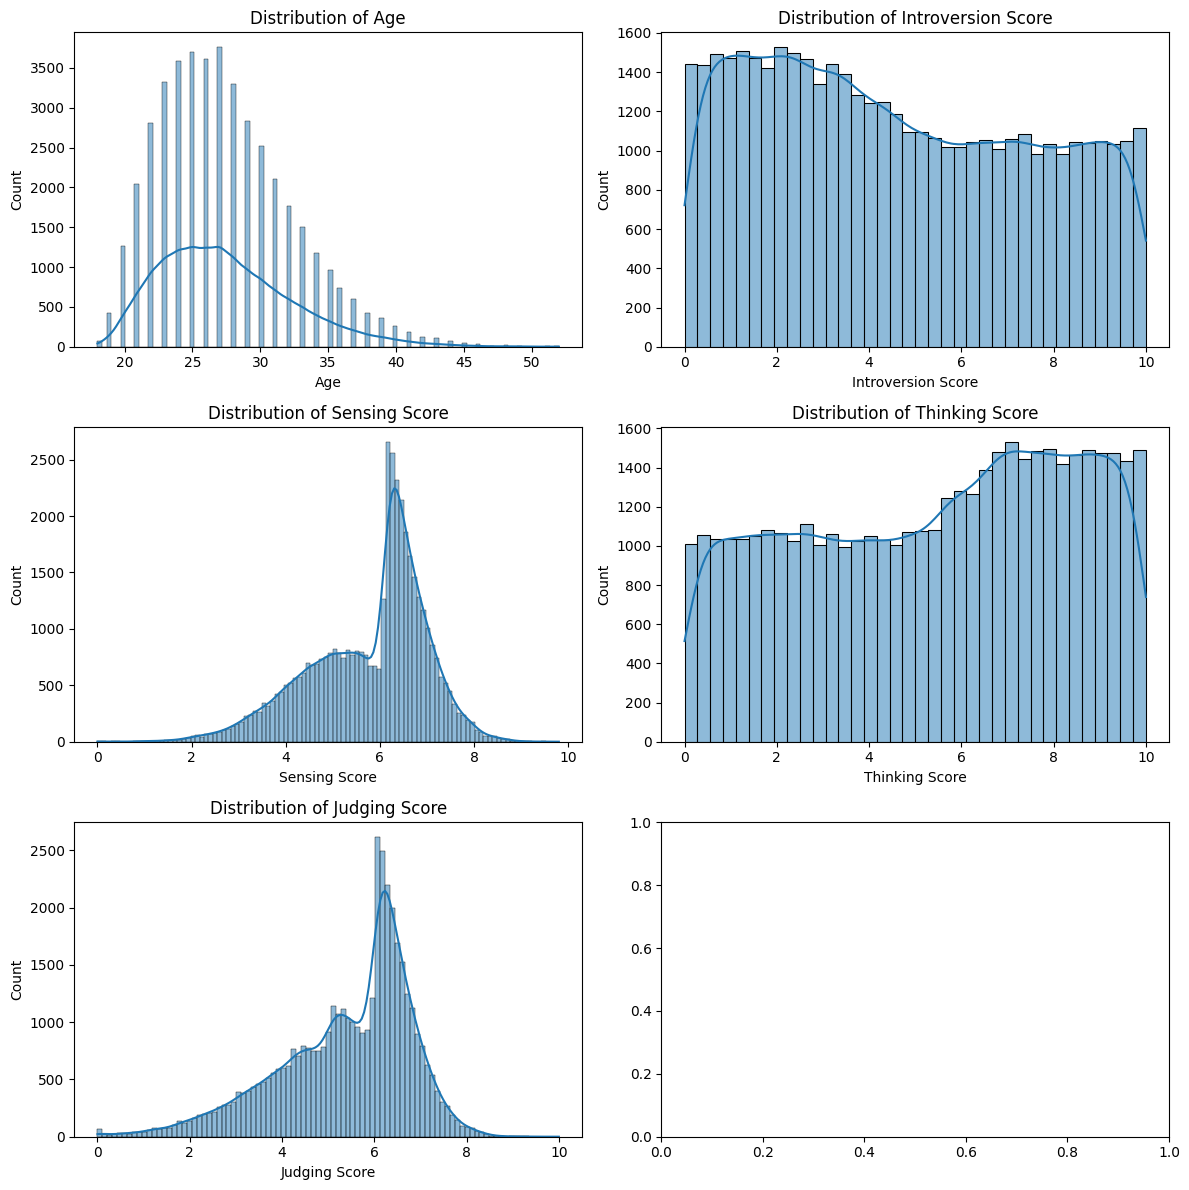

In [6]:
numerical_cols = ['Age', 'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score']

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for ax, col in zip(axs.ravel(), numerical_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

fig.tight_layout()

We can observe that the data distributions vary across all variables.

The distribution of the sensing score is very similar to that of the judging score. Both exhibit a large peak around values 6 and 7, followed by a noticeable drop toward higher numbers. They also show a moderate peak at 5 and then gradually decrease in a near-normal pattern.

The distribution of the thinking score appears to be almost uniform, with slightly higher counts at larger values. Similarly, the introversion score shows a comparable pattern, suggesting a possible correlation between the two variables.

Age is the variable that most closely resembles a normal distribution, although it is not perfectly symmetric.

None of these distributions suggests the need for power transformations, as none displays a pronounced skew or heavy tail. However, scaling techniques will be applied to ensure all variables are on a comparable scale.

We now proceed to check the distribution of cathegorical values within our dataset.

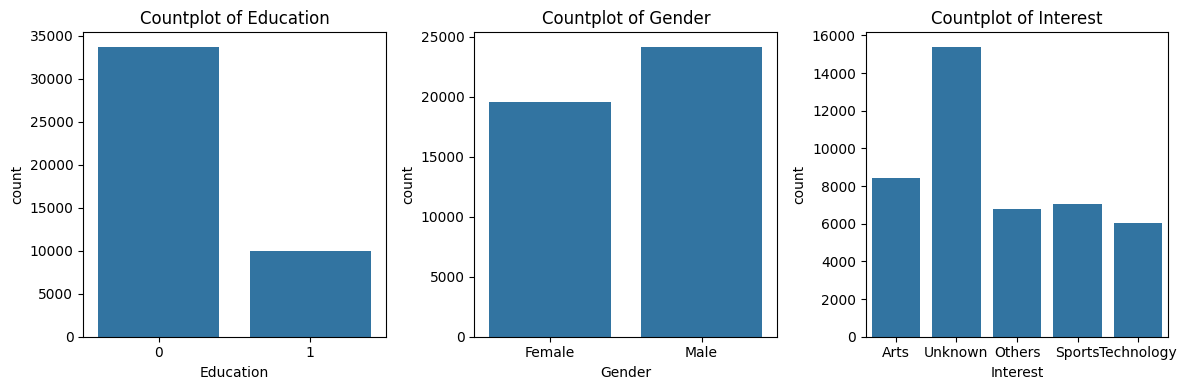

In [7]:
categorical_cols = ['Education', 'Gender', 'Interest']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axs.ravel(), categorical_cols):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Countplot of {col}')

fig.tight_layout()

Education, being a categorical variable, shows a significantly higher number of individuals who have not completed graduate studies and instead have achieved an undergraduate degree or lower.

In the gender variable, there are more males than females. Additionally, the interest variable shows a relatively similar distribution across categories.

For preprocessing categorical features, we will use one-hot encoding to convert the categorical variables into a format suitable for machine learning algorithms. This transformation will be applied to the Gender and Interest columns, which are stored as object types. The Education column will be omitted from one-hot encoding in order to preserve the natural ordinal relationship between education levels.

To better understand the target variable, we will observe its distribution.

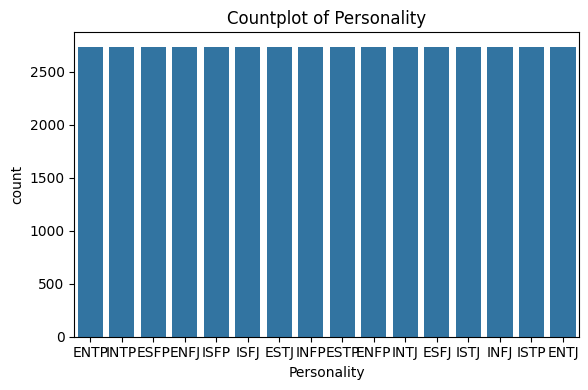

In [8]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Personality')
plt.title('Countplot of Personality')
plt.tight_layout()

We can observe that it has a perfect uniform distribution, with all classes appearing the same exact times.

We next create boxplots to compare the personality counts with the rest of the features.

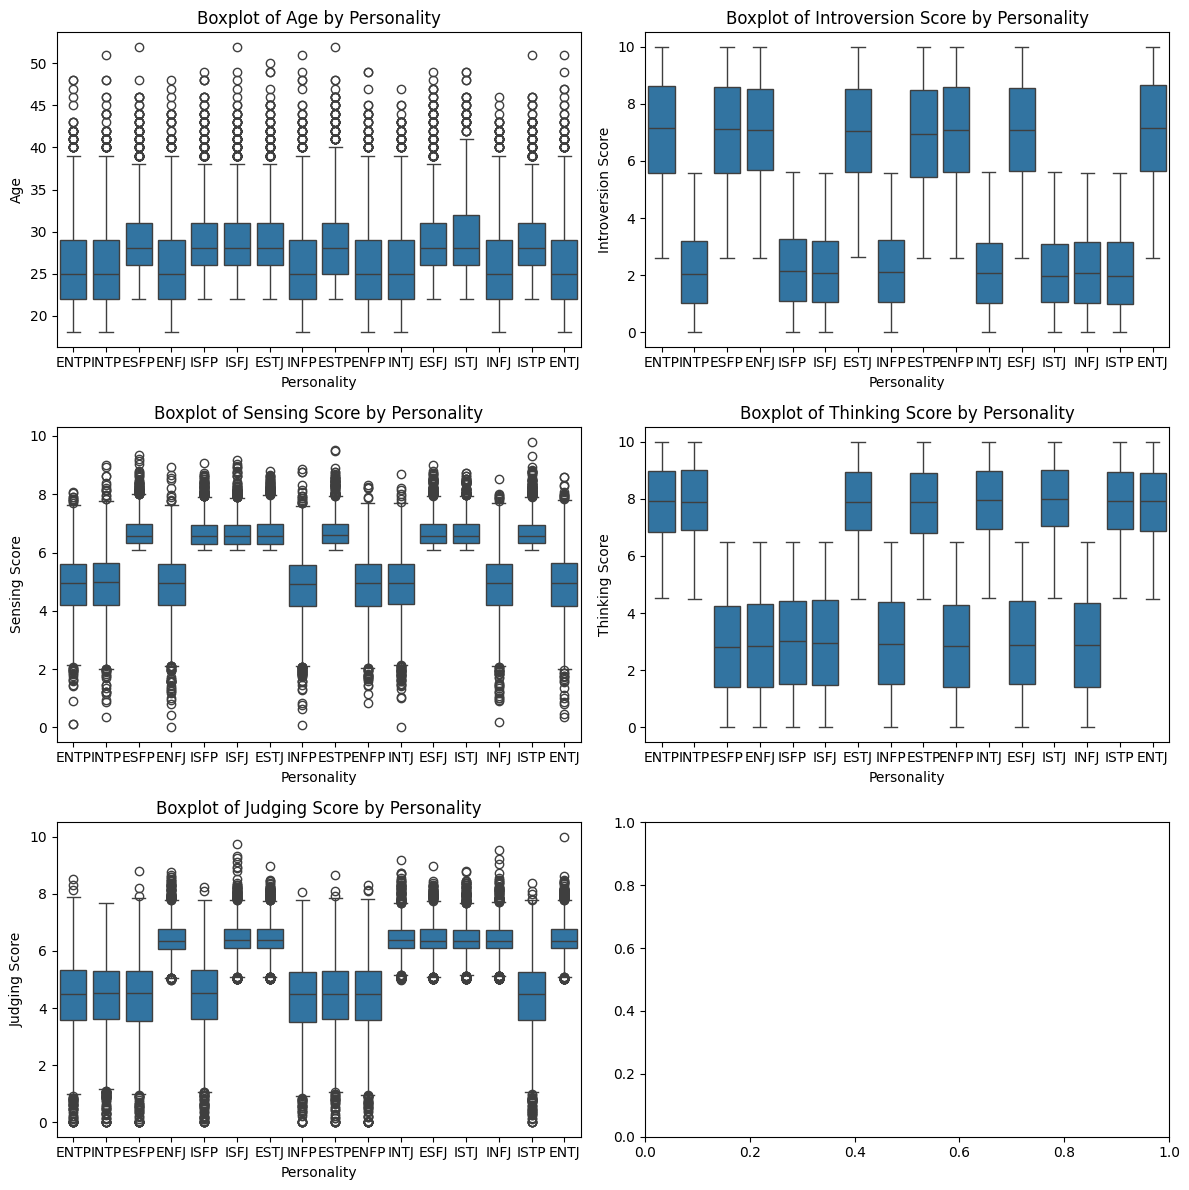

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for ax, col in zip(axs.ravel(), numerical_cols):
    sns.boxplot(data=data, x='Personality', y=col, ax=ax)
    ax.set_title(f'Boxplot of {col} by Personality')

fig.tight_layout()

There is a noticeable relation between the features and their personality, with all of the boxplots showing 8 features being higher than the 8 rest, which represent the opposing personality.

One of example of this is the judging score being higher in every personality that has a 'J' in the name, corresponding to Judging, compared to those who have a P instead, corresponding to Perceiving.

For categorical features, we can create countplots with hue set to Personality to visualize the counts within each category.

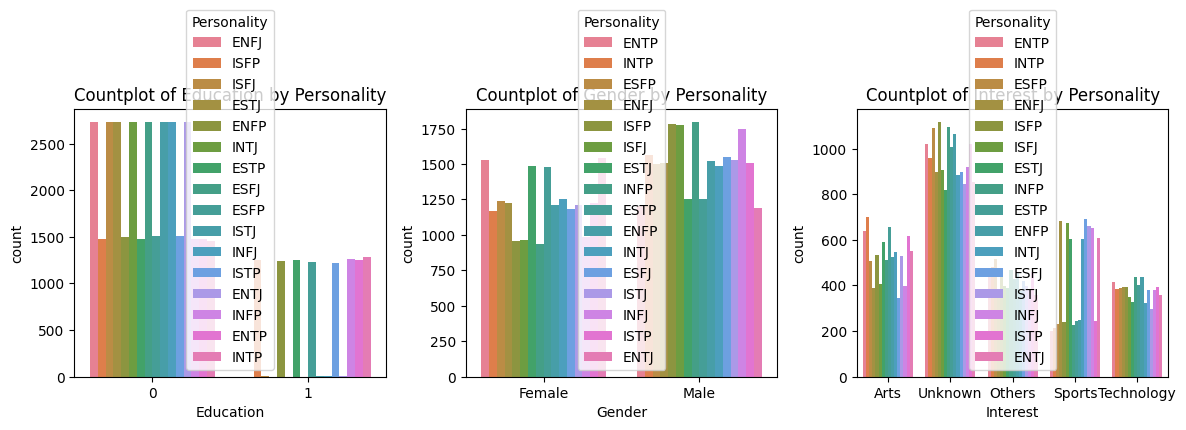

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, col in zip(axs.ravel(), categorical_cols):
    sns.countplot(data=data, x=col, hue='Personality', ax=ax)
    ax.set_title(f'Countplot of {col} by Personality')

fig.tight_layout()

From these count plots, the most notable observation is that certain personality types are completely absent among individuals with higher levels of education, such as ISFP and ENTJ.

Regarding gender, the distribution appears relatively balanced, with only minor fluctuations across personality types. A similar pattern can be observed in the interest variable, where variations exist but are not as pronounced as those seen in the education variable.

We can also use a correlation matrix heatmap to visualize the correlations between all numerical columns.

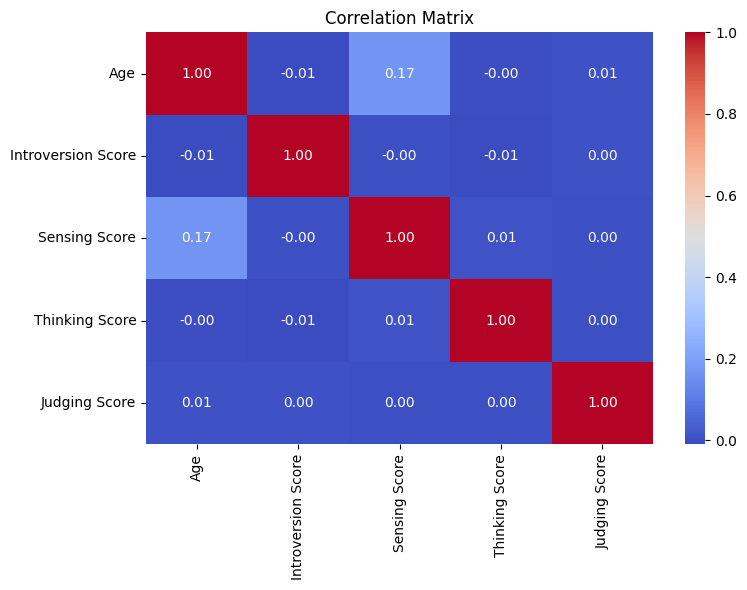

In [11]:
corr_matrix = data[['Age', 'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score']].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()

Surprisingly, there is little to no correlation among the numerical variables. The highest correlation observed is between age and sensing score, but aside from that, most values are extremely low, around 0.01 or 0.00.

For handling mission values, we can utilize a count plot to view them.

<Axes: >

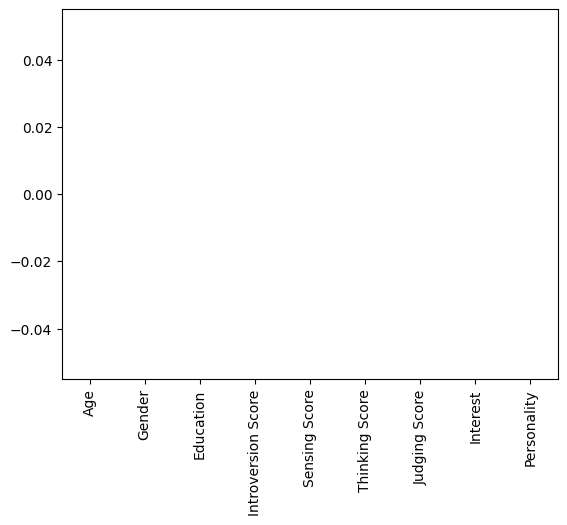

In [12]:
missing_counts = data.isnull().sum()
missing_counts.plot(kind='bar')

To no surprise, as seen in early descriptors of the dataset, there are no empty values.

In [13]:
missing_percent = data.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

,0
Age,0.0
Gender,0.0
Education,0.0
Introversion Score,0.0
Sensing Score,0.0
Thinking Score,0.0
Judging Score,0.0
Interest,0.0
Personality,0.0


The same can be viewed in this table.

## Preprocessing
---
For the preprocessing stage, we will apply the insights obtained from the previous analysis to the dataset's features.

In [14]:
preprocessing_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['Age', 'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score']),
            ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder()), ['Gender', 'Interest']),
        ],
        remainder='passthrough'
    )
)

To the Gender and Interest columns: Impute missing values with the most frequent value, followed by one-hot encoding.

To the Age, Introversion Score, Sensing Score, Thinking Score, and Judging Score columns: Impute missing values with the mean of the column, followed by standard scaling.

To the Education column: Pass through without any changes.

Any remaining columns will be passed through without any changes.

Now we need to define our feature matrix x and target vector y, followed by splitting the dataset into training and testing sets. We will use an 80-20 split, with stratification based on the target variable to ensure that both sets have a similar distribution of the target classes.

In [15]:
x = data[numerical_cols + categorical_cols]
y = data['Personality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

We can verify the class distribution in both the training and testing sets to ensure that stratification worked as intended.

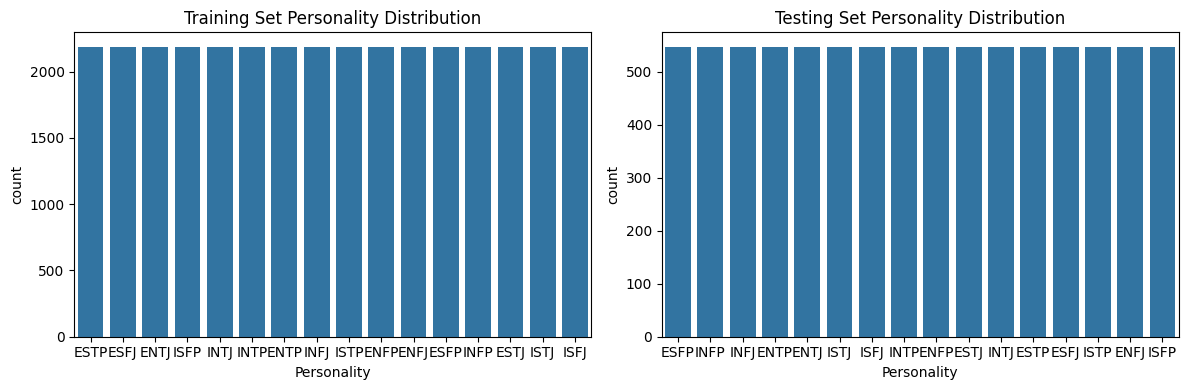

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Training Set Personality Distribution')
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Testing Set Personality Distribution')
fig.tight_layout()

We can confirm this because they all have the same quantity of appearances in each subset.

To apply the preprocessing pipeline, we can use the fit_transform method on the training data to fit the pipeline and transform the data in one step. For the testing data, we will use the transform method to apply the same transformations learned from the training data.

In [17]:
x_train_processed = preprocessing_pipeline.fit_transform(x_train, y_train)
x_train_processed

array([[-0.49858544,  1.44139467,  0.31274379, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2949036 ,  1.31857897,  0.80404606, ...,  0.        ,
         1.        ,  0.        ],
       [-0.2949036 ,  0.8416192 , -0.56301817, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.72350561,  1.21576062,  1.55499651, ...,  0.        ,
         0.        ,  1.        ],
       [-0.70226729,  1.08207643, -0.96561936, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.31614192,  1.26369222, -1.49750222, ...,  0.        ,
         1.        ,  1.        ]])

In [18]:
x_test_processed = preprocessing_pipeline.transform(x_test)
x_test_processed

array([[ 0.51982376, -0.56538731,  0.93326429, ...,  0.        ,
         0.        ,  0.        ],
       [-0.70226729, -1.43371962, -1.46530693, ...,  0.        ,
         1.        ,  1.        ],
       [-1.31331281, -1.38678702, -1.35674151, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.90594913, -0.48602492, -0.28197161, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2949036 , -0.07696654,  0.46869907, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11246008, -0.43226119,  1.43203075, ...,  0.        ,
         0.        ,  0.        ]])

## Building and training classification model
---
Now that we have our preprocessing pipeline set up, we can build a classification model using logistic regression. We will create a complete pipeline that includes both the preprocessing steps and the logistic regression model.

In [19]:
classification_model = make_pipeline(
    preprocessing_pipeline,
    LogisticRegression(max_iter=5000)
)

The classification_model object is now a complete pipeline that first preprocesses the input data and then applies logistic regression for classification. If we output the steps of the pipeline, we can see the individual components that make up the complete model.

In [20]:
classification_model

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'Introversion '
                                                                    'Score',
                                                                    'Sensing '
                                                                    'Score',
                                                                    'Thinking '
                                                                    'Score',
                                                                    'Judging '
                                                                    'Score']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder())]),
                                                                   ['Gender',
                                                                    'Interest'])]))])),
                ('logisticregression', LogisticRegression(max_iter=5000))])

Now that the pipeline is set up, we can fit the model to the training data using the fit method.

In [21]:
classification_model.fit(x_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'Introversion '
                                                                    'Score',
                                                                    'Sensing '
                                                                    'Score',
                                                                    'Thinking '
                                                                    'Score',
                                                                    'Judging '
                                                                    'Score']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder())]),
                                                                   ['Gender',
                                                                    'Interest'])]))])),
                ('logisticregression', LogisticRegression(max_iter=5000))])

## Evaluation of classification model
---
Now that we have trained the model, it is time to evaluate its performance using accuracy. I chose this metric because the target classes are perfectly balanced, making accuracy an appropriate evaluation measure.

We utilize grid search to find the best hyperparameters for the model.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "logisticregression__C": [0.01, 0.1, 1, 10, 100],
    "logisticregression__penalty": ["l2"],
    "logisticregression__solver": ["lbfgs", "liblinear"]
}

grid_search_logistic = GridSearchCV(
    classification_model,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search_logistic.fit(x_train, y_train)

best_model = grid_search_logistic.best_estimator_

print(grid_search_logistic.best_params_)

{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [23]:
grid_search_logistic.best_score_

np.float64(0.8613801971710243)

The best hyperparameters found were C = 100, using L2 regularization with the lbfgs solver.

GridSearchCV was performed using 5-fold cross-validation, optimizing accuracy. The best model achieved a mean cross-validation accuracy of 0.861.

We now evaluate the model with the accuracy metric, using the best combination of hyperparameters.

In [24]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, x, y):
  y_pred = model.predict(x)
  accsco = accuracy_score(y, y_pred)

  return {"Accuracy score": accsco}

train_metrics = evaluate_model(best_model, x_train, y_train)
test_metrics = evaluate_model(best_model, x_test, y_test)

print("Logistic regression")
metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

Logistic regression


,Accuracy score
Train,0.863923
Test,0.858841


The Logistic Regression model achieved an accuracy of 86.39% on the training set and 85.88% on the test set. The close values indicate that the model generalizes well and does not show signs of overfitting.

We will now observe the confusion matrix of this best-performing model.

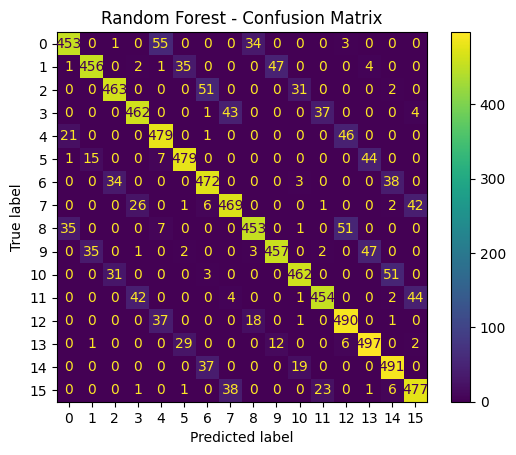

In [25]:
y_pred_test = best_model.predict(x_test)

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic regression - Confusion Matrix")
plt.show()

Here, we can observe the confusion matrix of the logistic regression model, using the test set. The yellow diagonal and the rest of the board being purple means that the model performs very well, with a few exceptions.

Finally, we will see the classification report that sklearn provides.

In [26]:
from sklearn.metrics import classification_report

y_pred_test = best_model.predict(x_test)

report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

        ENFJ       0.89      0.83      0.86       546
        ENFP       0.90      0.84      0.87       546
        ENTJ       0.88      0.85      0.86       547
        ENTP       0.87      0.84      0.85       547
        ESFJ       0.82      0.88      0.85       547
        ESFP       0.88      0.88      0.88       546
        ESTJ       0.83      0.86      0.84       547
        ESTP       0.85      0.86      0.85       547
        INFJ       0.89      0.83      0.86       547
        INFP       0.89      0.84      0.86       547
        INTJ       0.89      0.84      0.87       547
        INTP       0.88      0.83      0.85       547
        ISFJ       0.82      0.90      0.86       547
        ISFP       0.84      0.91      0.87       547
        ISTJ       0.83      0.90      0.86       547
        ISTP       0.84      0.87      0.85       547

    accuracy                           0.86      8749
   macro avg       0.86   

The classification report shows consistently strong performance across all personality types, with precision, recall, and F1-scores mostly between 0.83 and 0.91. The overall accuracy of 0.86, along with similar macro and weighted averages, confirms that the model performs uniformly across classes. This indicates balanced performance without bias toward any specific personality type.

## Serialization
---
Final step in this Colab is to serialize the model to utilize in another one.

In [27]:
import joblib

joblib.dump(classification_model, "personality_model.joblib")

['personality_model.joblib']

We finish by downloading the serialized model to our computer.

In [28]:
from google.colab import files

files.download("personality_model.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>